This file include the implementation of other methods for SGM-FC

1. eigenmapping

2. raw SC

# Import some pkgs

In [1]:
import sys
sys.path.append("../../mypkg")

import scipy
import itertools

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict
from collections import defaultdict as ddict
from IPython.display import display
%load_ext autoreload
%autoreload 2

In [2]:
# SBI and torch
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as sutils

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [3]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch
from utils.measures import geodesic_dist, reg_R_fn, lin_R_fn, lap_mat_fn

plt.style.use(FIG_ROOT/"base.mplstyle")

# Some fns

In [4]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x));
_remove_norm = lambda x: x/np.linalg.norm(x)
_std_vec = lambda x: (x-np.mean(x))/np.std(x)
_remove_scale = _minmax_vec
uptri_idxs = np.triu_indices(68, k=1);
# transfer vec to a sym mat
def _vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

In [5]:
def _get_base_metrics(fc, num_rep=1000):
    """Get baseline mse via random shuffling.
    """
    def _mse_err(ele1, ele2):
        fc1_c = _remove_scale(ele1)
        fc2_c = _remove_scale(ele2)
        return np.mean((fc1_c-fc2_c)**2)
    
    idxs = np.triu_indices_from(fc, k=1)
    eles = fc[idxs]
    eles_mm = _remove_scale(eles)
    
    metrics = edict()
    mses = []
    linrs = []
    regrs = []
    for ix in range(num_rep):
        rand_eles_mm = np.random.permutation(eles_mm)
        mses.append(np.mean((rand_eles_mm-eles_mm)**2))
        linrs.append(lin_R_fn(rand_eles_mm.reshape(1, -1), 
                              eles_mm.reshape(1, -1))[0])
        regrs.append(reg_R_fn(rand_eles_mm.reshape(1, -1), 
                              eles_mm.reshape(1, -1))[0])
    metrics.mse = [np.mean(mses), np.std(mses)]
    metrics.linr = [np.mean(linrs), np.std(linrs)]
    metrics.regr = [np.mean(regrs), np.std(regrs)]
    return metrics

In [6]:
from scipy.stats import kendalltau
from scipy.stats import spearmanr

def divide_fc(fc):
    """Divide the FC into three blocks and vectorize them
    """
    size_fc = len(fc)
    hs_fc = int(size_fc/2)
    fc_block1 = fc[:hs_fc, :hs_fc]
    fc_block2 = fc[hs_fc:, hs_fc:];
    fc_block3 = fc[:hs_fc, hs_fc:];
    vec1 = _remove_scale(fc_block1[np.triu_indices(hs_fc, k = 1)])
    vec2 = _remove_scale(fc_block2[np.triu_indices(hs_fc, k = 1)])
    vec3 = _remove_scale(fc_block3.flatten())
    return vec1, vec2, vec3

def cal_metrics(fc1, fc2):
    """Calculate the distance between fc1 and fc2, including
        1. geodesic dist
        2. pearson's R
        3. lin R
        4. pearson's R after divide the FC into three blocks
        5. lin R after divide the FC into three blocks
    """
    fc1 = fc1.astype(np.float64)
    fc2 = fc2.astype(np.float64)
    size_fc = len(fc1)
    
    fc1_c = _remove_scale(fc1[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    fc2_c = _remove_scale(fc2[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    
    # for geodedic
    #fc1_g = fc1/np.linalg.norm(fc1) + np.eye(size_fc)
    #fc2_g = fc2/np.linalg.norm(fc2) + np.eye(size_fc)
    #fc1_g = lap_mat_fn(_vec_2mat(fc1_c)) # I think the geodesic dist should be based on results after minmax
    #fc2_g = lap_mat_fn(_vec_2mat(fc2_c))
    fc1_g = _vec_2mat(fc1_c.reshape(-1)) + np.eye(size_fc)*3
    fc2_g = _vec_2mat(fc2_c.reshape(-1)) + np.eye(size_fc)*3 # make sure we get PD matrix
    
    
    # all metrics
    geo_dist = None #geodesic_dist(fc1_g, fc2_g)
    reg_r = reg_R_fn(fc1_c, fc2_c)
    lin_r = lin_R_fn(fc1_c, fc2_c)
    mse = np.mean((fc1_c-fc2_c)**2)
    tau_r = kendalltau(fc1_c.reshape(-1), fc2_c.reshape(-1))[0]
    sp_r = spearmanr(fc1_c.reshape(-1), fc2_c.reshape(-1))[0]
    
    # block wise metrics
    blocks1 = divide_fc(fc1)
    blocks2 = divide_fc(fc2)
    reg_r_block = [reg_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    lin_r_block = [lin_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    
    res = edict()
    res.geo_dist = geo_dist
    res.reg_r = reg_r[0]
    res.lin_r = lin_r[0]
    res.tau_r = tau_r
    res.sp_r = sp_r 
    res.mse = mse
    res.reg_r_block = np.mean(reg_r_block)
    res.lin_r_block = np.mean(lin_r_block)
    return res

def cal_metrics_batch(fc1s, fc2s):
    """fc1s, fc2s: num_fc x 68 x 68
    """
    ress = ddict(list)
    for ix in range(len(fc1s)):
        fc_t = fc2s[ix]
        fc_e = fc1s[ix]
        res = cal_metrics(fc_t, fc_e)
        for key, v in res.items():
            ress[key].append(v)
    
    return ress

# Load data and params

In [7]:
paras = edict()
paras.bds = ["delta", "theta", "alpha", "beta_l"]
#paras.bds = ["alpha"]
paras.allbds = ["delta", "theta", "alpha", "beta_l"]
paras.add_v = 0.01
paras.nepoch = 100

In [8]:
# em FC
fc_root = RES_ROOT/"emp_fcs2"
def _get_fc(sub_ix, bd):
    fil = list(fc_root.rglob(f"*{bd}*{paras.nepoch}/sub{sub_ix}.pkl"))[0]
    return np.abs(load_pkl(fil, verbose=False))

In [9]:
# fc from NMM
def _get_nmm_fc(sub_ix, bd):
    nmm_fc_root = RES_ROOT/(f"rawfc2_NMM_{bd}_ep{paras.nepoch}_"
                            f"losslinr_addv{paras.add_v*100:.0f}")
    fil = list(nmm_fc_root.glob(f"ind{sub_ix}.pkl"))[0]
    return np.abs(load_pkl(fil, verbose=False))

In [10]:
# fc from ANN
def _get_ann_fc(sub_ix, bd):
    fc_root = RES_ROOT/(f"rawfc2_ANN_{bd}_ep{paras.nepoch}_"
                        f"addv{paras.add_v*100:.0f}")
    fil = list(fc_root.glob(f"ind{sub_ix}.pkl"))[0]
    return np.abs(load_pkl(fil, verbose=False).bestfc[:68, :68])


In [11]:
# fc from ANN allband
def _get_annab_fc(sub_ix, bd):
    fc_root = RES_ROOT/(f"rawfc2allbd_ANN_{'-'.join(paras.allbds)}_ep{paras.nepoch}_"
                        f"addv{paras.add_v*100:.0f}")
    fil = list(fc_root.glob(f"ind{sub_ix}.pkl"))[0]
    return np.abs(load_pkl(fil, verbose=False).bestfc[paras.bds.index(bd)][:68, :68])


In [12]:

def _add_v2con(cur_ind_conn, add_v):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.quantile(cur_ind_conn, 0.99)*add_v # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], np.diag(cur_ind_conn[:34, 34:68]) + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], np.diag(cur_ind_conn[34:68, :34]) + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], np.diag(cur_ind_conn[68:77, 77:]) + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], np.diag(cur_ind_conn[77:, 68:77]) + add_v)
    return cur_ind_conn


In [13]:
def _sgm_step_fn(sc):
    rowdegree = np.transpose(np.sum(sc, axis=1))
    coldegree = np.sum(sc, axis=0)
    qind = rowdegree + coldegree < 0.2 * np.mean(rowdegree + coldegree)
    rowdegree[qind] = np.inf
    coldegree[qind] = np.inf
    L2 = np.divide(1, np.sqrt(np.multiply(rowdegree, coldegree)) + np.spacing(1))
    scn = np.matmul(np.diag(L2), sc)
    return scn

In [14]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values;
#scs = ind_conn.transpose(2, 0, 1)[:, :68, :68];
#scs = np.array([_preprocess_sc(sc) for sc in scs]);

scs = []
for cur_ind_idx in range(36):
    # create spectrome brain:
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
     # re-assign connectome to individual connectome
    brain.connectome =  _add_v2con(ind_conn[:, :, cur_ind_idx], paras.add_v)
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    sc = brain.reducedConnectome
    scs.append(sc[:68, :68])
scs = np.array(scs)
scs.shape

(36, 68, 68)

In [15]:
base_mses = ddict(list)
base_linrs = ddict(list)
base_regrs = ddict(list)
for band in paras.bds:
    for sub_ix in trange(36, desc=f"{band}"):
        metrics = _get_base_metrics(_get_fc(sub_ix, band)) 
        base_mses[band].append(metrics.mse)
        base_linrs[band].append(metrics.linr)
        base_regrs[band].append(metrics.regr)

beta_l: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:05<00:00,  6.36it/s]


# Eigenmapping

In [16]:
from scipy.optimize import minimize
class EigMapping():
    """Do eigenmapping approx from SC to FC.
       lamnew = exp(-lam(SC)*p1)+p2 from ben
    """
    def __init__(self, sc, init_ps, rescale_fn=lambda x: x):
        """args:
            sc: the SC matrix
            init_ps: Initial guess of the parameters, a list of two
            rescale_fn: The fn for rescale fc, default is the identity, minmax does not converge.
        """
        
        self.init_ps = init_ps
        #sc = np.diag(1/np.sum(sc, axis=0)) @ sc
        self.eigvals, self.eigvecs = self._get_eigres(sc)
        self.rescale_fn = rescale_fn
        self.opt_ps = None
         
    def _get_eigres(self, sc):
        eigvals, eigvecs = np.linalg.eig(sc);
        sort_idxs = np.argsort(-np.abs(eigvals))
        eigvals, eigvecs = eigvals[sort_idxs], eigvecs[:, sort_idxs]
        return eigvals, eigvecs
        
    def _recon_fc(self, ps=None):
        p1, p2 = ps
        new_eigvals = np.exp(-p1*self.eigvals/np.median(self.eigvals))+p2
        # note that for an ordinary matrix, it should be Ulam U^-1
        #rec_fc = self.eigvecs @ np.diag(new_eigvals) @ np.linalg.inv(self.eigvecs)
        rec_fc = self.eigvecs @ np.diag(new_eigvals) @ self.eigvecs.T
        return rec_fc - np.diag(np.diag(rec_fc))
    
    def opt(self, fc):
        def fun(ps):
            newfc = self._recon_fc(ps)
            idxs = np.triu_indices_from(newfc, k=1)
            return -lin_R_fn(self.rescale_fn(fc[idxs]), self.rescale_fn(newfc[idxs]))[0]
            #return np.mean((self.rescale_fn(fc[idxs])-
            #                self.rescale_fn(newfc[idxs]))**2)
        res = minimize(fun, self.init_ps, bounds= ((0, 1000), (-1000, 1000)), 
                      options=dict(disp=False))
        self.opt_ps = res.x
        if not res.success:
            print(f"May not converge, {res.message}.")
            
    def get_optfc(self, fc):
        if self.opt_ps is None:
            self.opt(fc)
        return self._recon_fc(self.opt_ps)

In [17]:
class EigMapping2():
    """Do eigenmapping approx from SC to FC.
       lamnew = lam(SC)/p * exp(-lam(SC)/p)
    """
    def __init__(self, sc, init_p, rescale_fn=lambda x: x):
        """args:
            sc: the SC matrix
            init_p: Initial guess of the parameter, number
            rescale_fn: The fn for rescale fc, default is the identity, minmax does not converge.
        """
        
        self.init_p = init_p
        self.eigvals, self.eigvecs = self._get_eigres(sc)
        self.rescale_fn = rescale_fn
        self.opt_p = None
         
    def _get_eigres(self, sc):
        eigvals, eigvecs = np.linalg.eig(sc);
        sort_idxs = np.argsort(-np.abs(eigvals))
        eigvals, eigvecs = eigvals[sort_idxs], eigvecs[:, sort_idxs]
        return eigvals, eigvecs
        
    def _recon_fc(self, p=None):
        new_eigvals = (np.exp(-self.eigvals/np.median(self.eigvals)/p)
                       *self.eigvals/np.median(self.eigvals)/p)
        # note that for an ordinary matrix, it should be Ulam U^-1
        rec_fc = self.eigvecs @ np.diag(new_eigvals) @ self.eigvecs.T
        return rec_fc - np.diag(np.diag(rec_fc))
    
    def opt(self, fc):
        def fun(p):
            newfc = self._recon_fc(p)
            idxs = np.triu_indices_from(newfc, k=1)
            return -lin_R_fn(self.rescale_fn(fc[idxs]), self.rescale_fn(newfc[idxs]))[0]
            #return np.mean((self.rescale_fn(fc[idxs])-
            #                self.rescale_fn(newfc[idxs]))**2)
        res = minimize(fun, (self.init_p, ), bounds= [(0, 1000)], 
                      options=dict(disp=False))
        self.opt_p = res.x
        if not res.success:
            print(f"May not converge, {res.message}.")
            
    def get_optfc(self, fc):
        if self.opt_p is None:
            self.opt(fc)
        return self._recon_fc(self.opt_p)

In [18]:
estfcs_eig = edict()
band = "delta"
for band in paras.bds:
    tmp= []
    for sub_ix in trange(scs.shape[0], desc=f"{band}"):
        opt = EigMapping(scs[sub_ix], [0, 0]) 
        curfc = _get_fc(sub_ix, band)
        tmp.append(opt.get_optfc(curfc));
    estfcs_eig[band] = np.array(tmp)

beta_l: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 14.37it/s]


# Compare all methods

In [162]:
def _get_metric_std(df, base_mse, base_linr, base_regr):
    base_mse = np.array(base_mse)
    base_linr = np.array(base_linr)
    base_regr = np.array(base_regr)
    df["mse_std"] = (df["mse"] - base_mse[:, 0])/base_mse[:, 1]
    df["lin_r_std"] = (df["lin_r"] - base_linr[:, 0])/base_linr[:, 1]
    df["reg_r_std"] = (df["reg_r"] - base_regr[:, 0])/base_regr[:, 1]
    return df

key_names = ['mse', 'lin_r', 'reg_r', "mse_std", 'lin_r_std',  "reg_r_std"]
#key_names = ['mse', "mse_std", 'lin_r', 'lin_r_std', 'geo_dist', 
#             'reg_r', 'tau_r', 'sp_r', 'reg_r_block', "lin_r_block"]
method_names = ["SGM-ANN", 
                "SGM-SBI", 
                "SGM-ANN-allbd", 
                "SGM-SBI-allbd", 
                "NMM",
                "Eigen",
                "SC", 
                ]
band_res = edict()
for band in paras.allbds:
    sbi_ann_res = load_pkl(RES_ROOT/(f"rawfc2_SBIxANNBW_{band}_"
                                     f"ep{paras.nepoch}_"
                                     f"num1000_densitynsf_MR3_noise_sd120_"
                                     f"addv{paras.add_v*100:.0f}"
                                     f"/inf_res.pkl"), verbose=False);
    sbi_ann_ab_res = load_pkl(RES_ROOT/(f"rawfc2allbd_SBIxANNALLBD_"
                                        f"{'-'.join(paras.allbds)}_"
                                        f"ep{paras.nepoch}_"
                                        f"num1000_densitynsf_MR3_noise_sd120_"
                                        f"addv{paras.add_v*100:.0f}"
                                        f"/inf_res.pkl"), verbose=False);
    empfcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);
    
    fcss = edict()
    fcss["SGM-SBI"] = np.array([np.abs(est_FC) for est_FC in sbi_ann_res.est_FCs]);
    fcss["SGM-ANN"] = np.array([_get_ann_fc(sub_ix, band) for sub_ix in range(36)]);
    fcss["SGM-SBI-allbd"]= np.array([np.abs(est_FC) for est_FC in sbi_ann_ab_res[f"est_FCs_{band}"]])
    fcss["SGM-ANN-allbd"] = np.array([_get_annab_fc(sub_ix, band) for sub_ix in range(36)]);
    fcss["NMM"] = np.array([_get_nmm_fc(sub_ix, band) for sub_ix in range(36)]);
    fcss["SC"] = scs
    fcss["Eigen"] = estfcs_eig[band]
    
    ress = edict()
    ress_full = edict()
    for key in method_names:
        tres =  pd.DataFrame(cal_metrics_batch(fcss[key], empfcs));
        ress_full[key] = tres
        ress[key] = _get_metric_std(tres, 
                                    base_mses[band], 
                                    base_linrs[band], 
                                    base_regrs[band]).mean()[key_names]
    
    out_df = pd.DataFrame(ress).T
    print(f"Results of {band}")
    display(out_df)
    band_res[band] = ress_full

Results of delta


,mse,lin_r,reg_r,mse_std,lin_r_std,reg_r_std
SGM-ANN,0.052673,0.436898,0.442051,-22.582811,20.958447,21.206514
SGM-SBI,0.052167,0.435688,0.442424,-22.827962,20.900920,21.224054
SGM-ANN-allbd,0.049629,0.418946,0.427566,-24.022982,20.100314,20.513091
SGM-SBI-allbd,0.048318,0.415710,0.436105,-24.673868,19.944710,20.923462
NMM,0.068221,0.230013,0.240922,-15.040957,11.051708,11.570463
Eigen,0.073405,0.285052,0.384188,-12.761259,13.689267,18.441337
SC,0.099926,0.288508,0.405613,-0.016750,13.847571,19.464465


Results of theta


,mse,lin_r,reg_r,mse_std,lin_r_std,reg_r_std
SGM-ANN,0.052413,0.425172,0.449528,-22.492276,20.422133,21.590358
SGM-SBI,0.052011,0.424801,0.449915,-22.695124,20.404283,21.608989
SGM-ANN-allbd,0.050768,0.413281,0.449144,-23.314595,19.850401,21.571516
SGM-SBI-allbd,0.051018,0.400090,0.448740,-23.199406,19.218714,21.551476
NMM,0.065977,0.218248,0.237504,-15.725116,10.492155,11.411569
Eigen,0.069928,0.300753,0.396569,-14.007173,14.448513,19.047113
SC,0.095726,0.300449,0.413894,-1.392258,14.439108,19.882979


Results of alpha


,mse,lin_r,reg_r,mse_std,lin_r_std,reg_r_std
SGM-ANN,0.054215,0.338969,0.430168,-20.926180,16.170384,20.522876
SGM-SBI,0.053550,0.336625,0.424006,-21.245121,16.058037,20.227102
SGM-ANN-allbd,0.056605,0.333874,0.441527,-19.787285,15.924440,21.073296
SGM-SBI-allbd,0.055691,0.333647,0.436770,-20.231040,15.915130,20.847170
NMM,0.061889,0.213228,0.234670,-17.060300,10.175909,11.201936
Eigen,0.064950,0.318249,0.407238,-15.614503,15.171797,19.424531
SC,0.088679,0.320667,0.429861,-3.837571,15.297436,20.514454


Results of beta_l


,mse,lin_r,reg_r,mse_std,lin_r_std,reg_r_std
SGM-ANN,0.052355,0.284104,0.310369,-20.927019,13.521618,14.770210
SGM-SBI,0.052297,0.278027,0.307129,-20.956045,13.233992,14.617469
SGM-ANN-allbd,0.054740,0.226437,0.263405,-19.706152,10.784549,12.540090
SGM-SBI-allbd,0.055080,0.223642,0.257518,-19.529706,10.651362,12.259372
NMM,0.064832,0.134828,0.144701,-14.531214,6.428996,6.898809
Eigen,0.061515,0.329365,0.413946,-16.323033,15.691672,19.712884
SC,0.084904,0.327686,0.432767,-4.399765,15.607992,20.605295


In [164]:
def get_cohend(vec1, vec2):
    diff = np.mean(vec1) - np.mean(vec2)
    pooled_std = np.std(np.concatenate((vec1, vec2)), ddof=2)
    cohend = diff/pooled_std
    return cohend
key_names = ['mse', 'lin_r', 'reg_r']
method_names = [
                "SGM-SBI", 
                "SGM-SBI-allbd",
                "Eigen",
                "SC", 
                ]
for band in paras.allbds:
    sbi_ann_res = load_pkl(RES_ROOT/(f"rawfc2_SBIxANNBW_{band}_"
                                     f"ep{paras.nepoch}_"
                                     f"num1000_densitynsf_MR3_noise_sd120_"
                                     f"addv{paras.add_v*100:.0f}"
                                     f"/inf_res.pkl"), verbose=False);
    sbi_ann_ab_res = load_pkl(RES_ROOT/(f"rawfc2allbd_SBIxANNALLBD_"
                                        f"{'-'.join(paras.allbds)}_"
                                        f"ep{paras.nepoch}_"
                                        f"num1000_densitynsf_MR3_noise_sd120_"
                                        f"addv{paras.add_v*100:.0f}"
                                        f"/inf_res.pkl"), verbose=False);
    empfcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);
    
    fcss = edict()
    fcss["SGM-SBI"] = np.array([np.abs(est_FC) for est_FC in sbi_ann_res.est_FCs]);
    fcss["SGM-SBI-allbd"]= np.array([np.abs(est_FC) for est_FC in sbi_ann_ab_res[f"est_FCs_{band}"]])
    fcss["SGM-ANN"] = np.array([_get_ann_fc(sub_ix, band) for sub_ix in range(36)]);
    fcss["SC"] = scs
    fcss["Eigen"] = estfcs_eig[band]
    
    ress = edict()
    ress_full = edict()
    for key in method_names:
        tres =  pd.DataFrame(cal_metrics_batch(fcss[key], empfcs));
        ress_full[key] = _get_metric_std(tres, 
                                    base_mses[band], 
                                    base_linrs[band], 
                                    base_regrs[band])
    print("="*100)
    for key in key_names:
        vec1 = ress_full["SGM-SBI"][key]
        vec2 = ress_full["SGM-SBI-allbd"][key]
        vec3 = ress_full["Eigen"][key]
        vec4 = ress_full["SC"][key]
        pv2 = scipy.stats.wilcoxon(vec1, vec2).pvalue
        pv3 = scipy.stats.wilcoxon(vec1, vec3).pvalue
        pv4 = scipy.stats.wilcoxon(vec1, vec4).pvalue
        print(f"In {band:>6} band with {key.title():>6} metric, "
              f"Pvals are {pv2:>5.4f} ({get_cohend(vec1, vec2):>6.3f}) "
              f"and {pv3:>5.4f} ({get_cohend(vec1, vec3):>6.3f})."
              f"and {pv4:>5.4f} ({get_cohend(vec1, vec4):>6.3f})."
             )

In  delta band with    Mse metric, Pvals are 0.0000 ( 0.480) and 0.0000 (-1.259).and 0.0000 (-1.653).
In  delta band with  Lin_R metric, Pvals are 0.0000 ( 0.388) and 0.0000 ( 1.531).and 0.0000 ( 1.597).
In  delta band with  Reg_R metric, Pvals are 0.0031 ( 0.122) and 0.0000 ( 0.931).and 0.0000 ( 0.695).
In  theta band with    Mse metric, Pvals are 0.0000 ( 0.084) and 0.0000 (-1.039).and 0.0000 (-1.558).
In  theta band with  Lin_R metric, Pvals are 0.0000 ( 0.373) and 0.0000 ( 1.311).and 0.0000 ( 1.393).
In  theta band with  Reg_R metric, Pvals are 0.7178 ( 0.021) and 0.0000 ( 0.815).and 0.0000 ( 0.639).
In  alpha band with    Mse metric, Pvals are 0.0104 (-0.207) and 0.0000 (-0.906).and 0.0000 (-1.608).
In  alpha band with  Lin_R metric, Pvals are 0.0018 ( 0.050) and 0.0040 ( 0.273).and 0.0031 ( 0.280).
In  alpha band with  Reg_R metric, Pvals are 0.1315 (-0.204) and 0.0131 ( 0.250).and 0.5824 (-0.099).
In beta_l band with    Mse metric, Pvals are 0.0000 (-0.452) and 0.0000 (-0.911).a

# Plot

In [172]:
import matplotlib.cm as cm
cmap = cm.get_cmap("tab10");
all_methods = [
                "SGM-ANN", 
                "SGM-SBI", 
                "SGM-ANN-allbd", 
                "SGM-SBI-allbd", 
                "NMM",
                "Eigen",
                "SC"];
cols = cmap(np.linspace(0, 1, len(all_methods)));
method_cols = {m:v for m, v in zip(all_methods, cols)};

# standard name
metrics_name = ["Standardized MSE", 
                "Standardized Lin's Corr", 
                "Standardized Pearson's Corr", 
                "Pearson's Corr"]
bands_name = [
    "Delta", "Theta", "Alpha", "Beta"
]

['Delta', 'Theta', 'Alpha', 'Beta']

##  Main plot

In [173]:
method_names = [
                #"SGM-ANN", 
                "SGM-SBI", 
                #"SGM-ANN-allbd", 
                "SGM-SBI-allbd", 
                "NMM",
                "Eigen",
                "SC"]
df_plots = []
for band in paras.allbds:
    ress_full = band_res[band]
    df_plot = pd.concat([ress_full[key] for key in method_names]);
    df_plot["Method"] = np.concatenate([
        [key] * 36 for key in method_names
    ])
    df_plot["Band"] = [band] * df_plot.shape[0]
    df_plots.append(df_plot)
df_plots = pd.concat(df_plots);

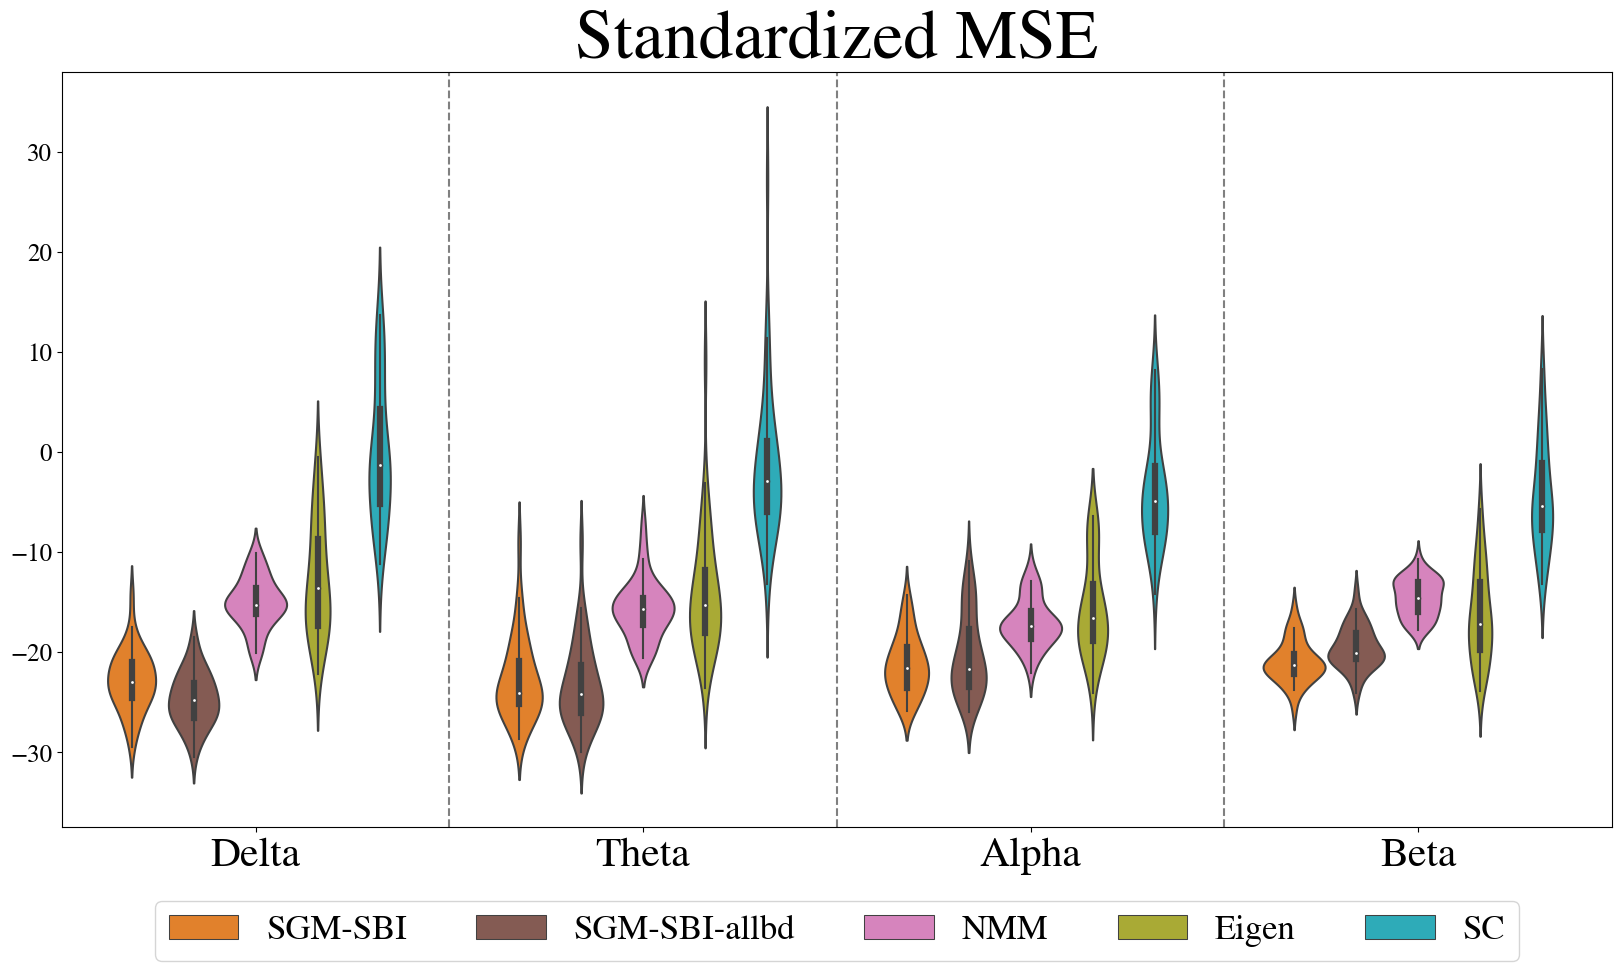

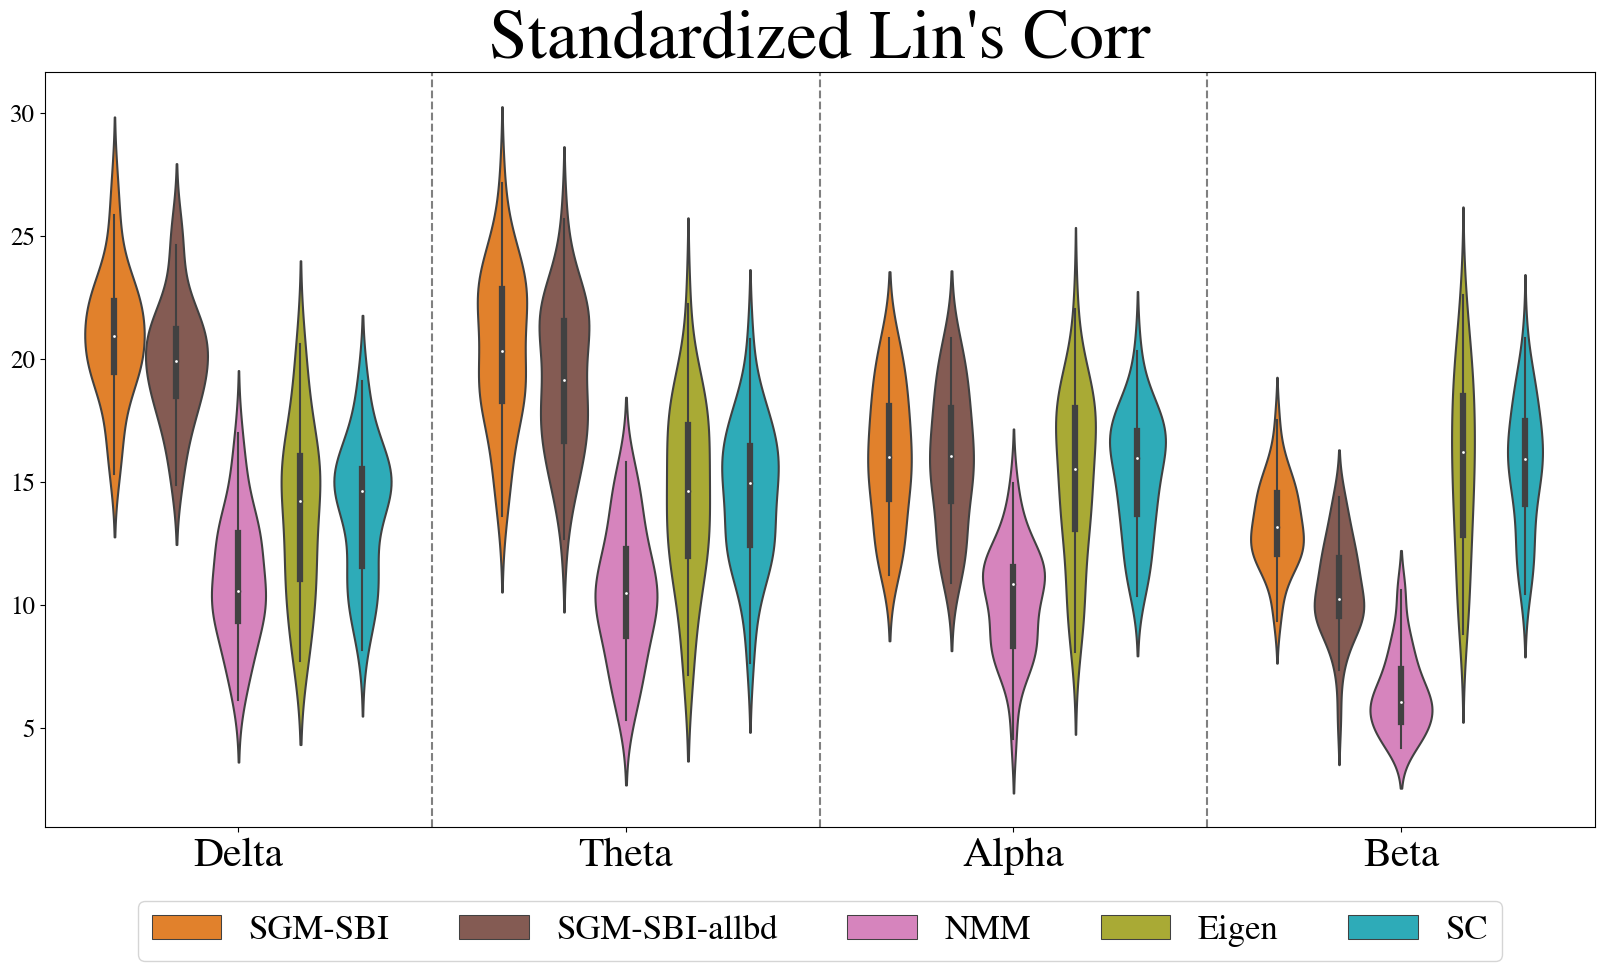

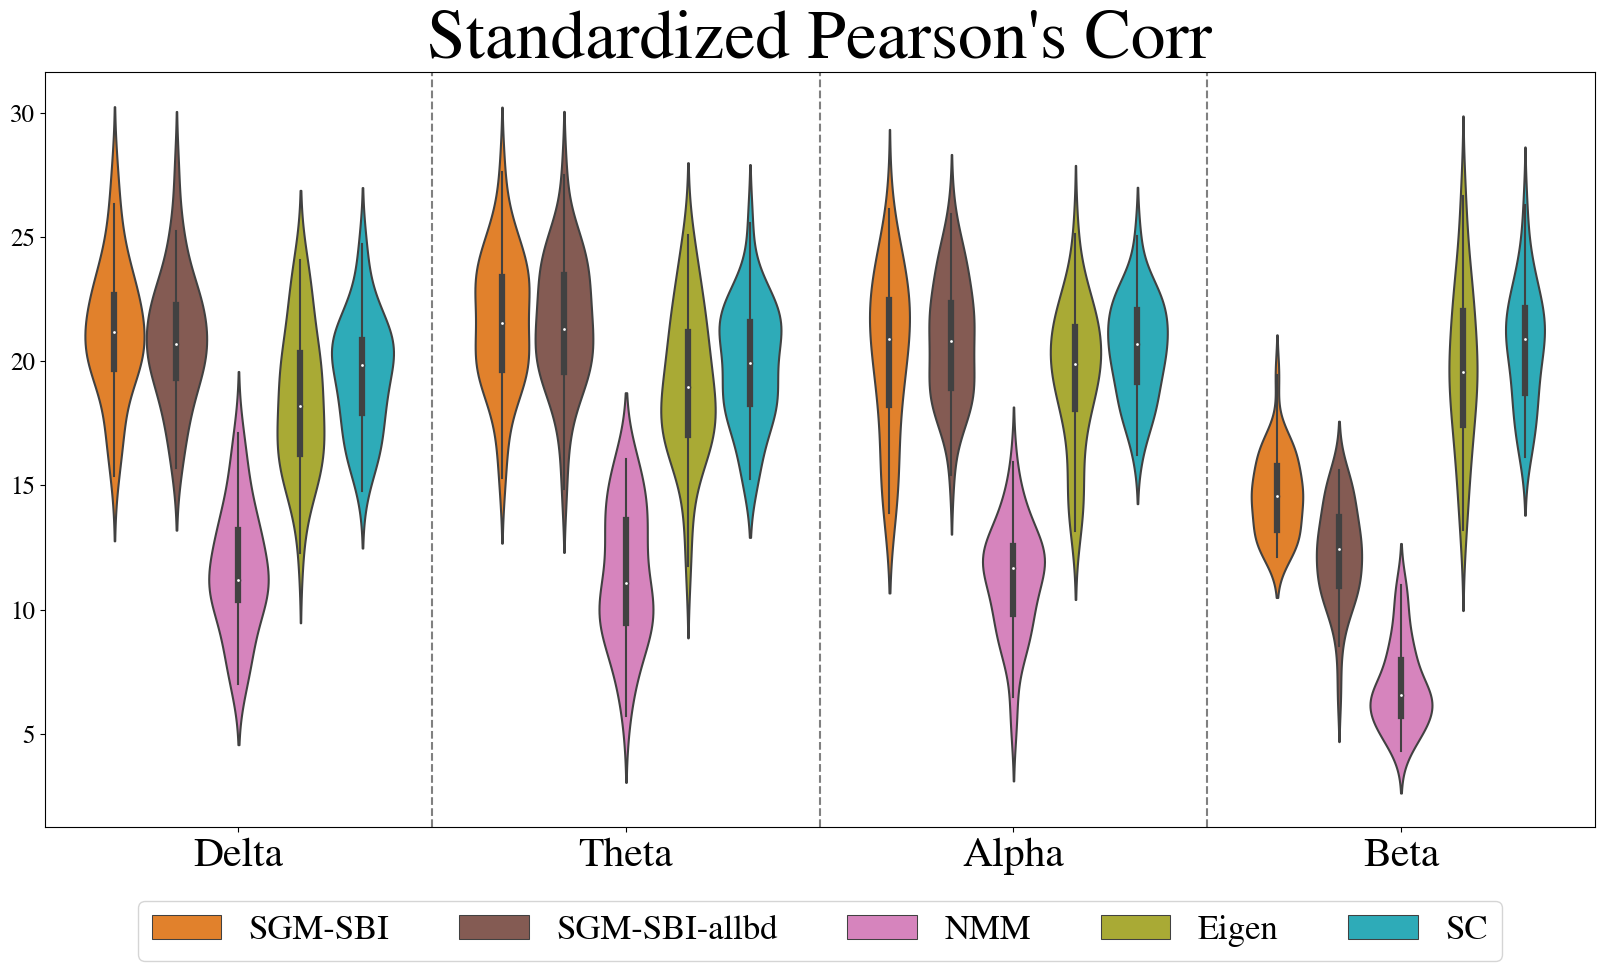

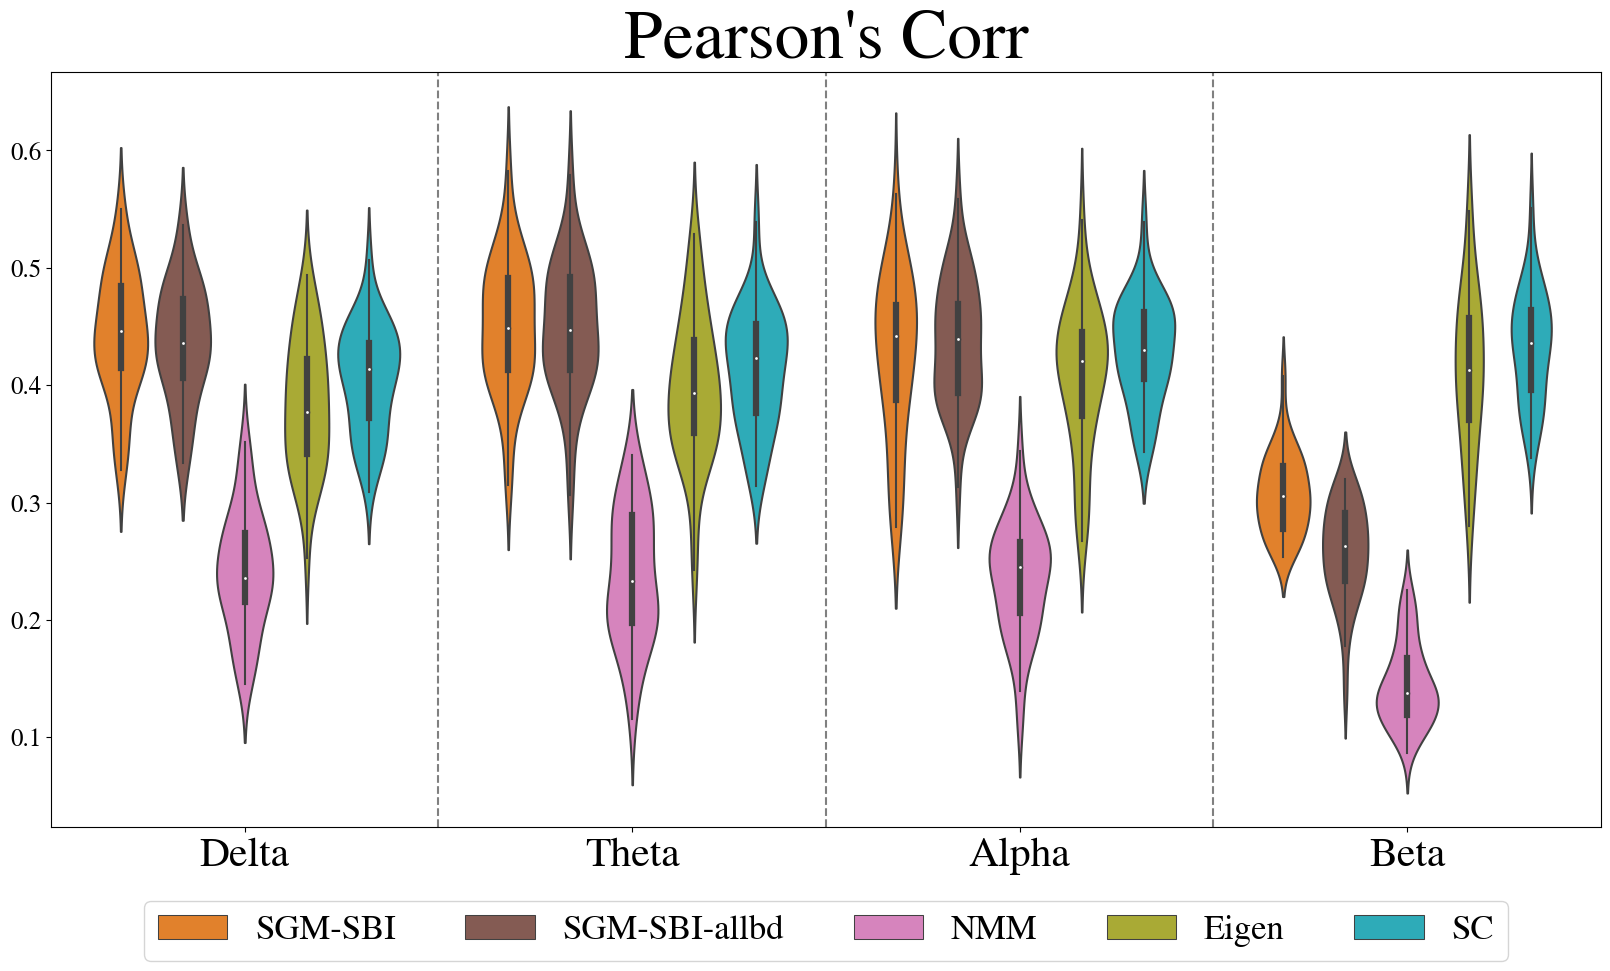

In [174]:
metrics = ["mse_std", "lin_r_std", "reg_r_std", "reg_r"]
                
for metric in metrics:
    plt.figure(figsize=[20, 10])
    plt.title(f"{metrics_name[metrics.index(metric)]}", fontsize=50)
    ax = sns.violinplot(x='Band', y=metric, hue="Method", 
                        data=df_plots, split=False, palette=method_cols)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(np.arange(len(paras.allbds)), bands_name, fontsize=30)
    # put the legend alongside the violinplot
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5) 
    
    keys = df_plots['Band'].unique()
    for key_idx, key in enumerate(keys):
        if key_idx < len(keys) - 1:
            ax.axvline(x=key_idx + 0.5, color='grey', linestyle='--')
    plt.savefig(FIG_ROOT/f"{metric}_cmp_results.jpg")

## Supp

In [26]:
method_names = [
                "SGM-ANN+SBI", 
                "SGM-ANN+SBI-allbd",
                "SGM-ANN", 
                "SGM-ANN-allbd", 
                ]
df_plots = []
for band in paras.allbds:
    ress_full = band_res[band]
    df_plot = pd.concat([ress_full[key] for key in method_names]);
    df_plot["Method"] = np.concatenate([
        [key] * 36 for key in method_names
    ])
    df_plot["Band"] = [band] * df_plot.shape[0]
    df_plots.append(df_plot)
df_plots = pd.concat(df_plots);

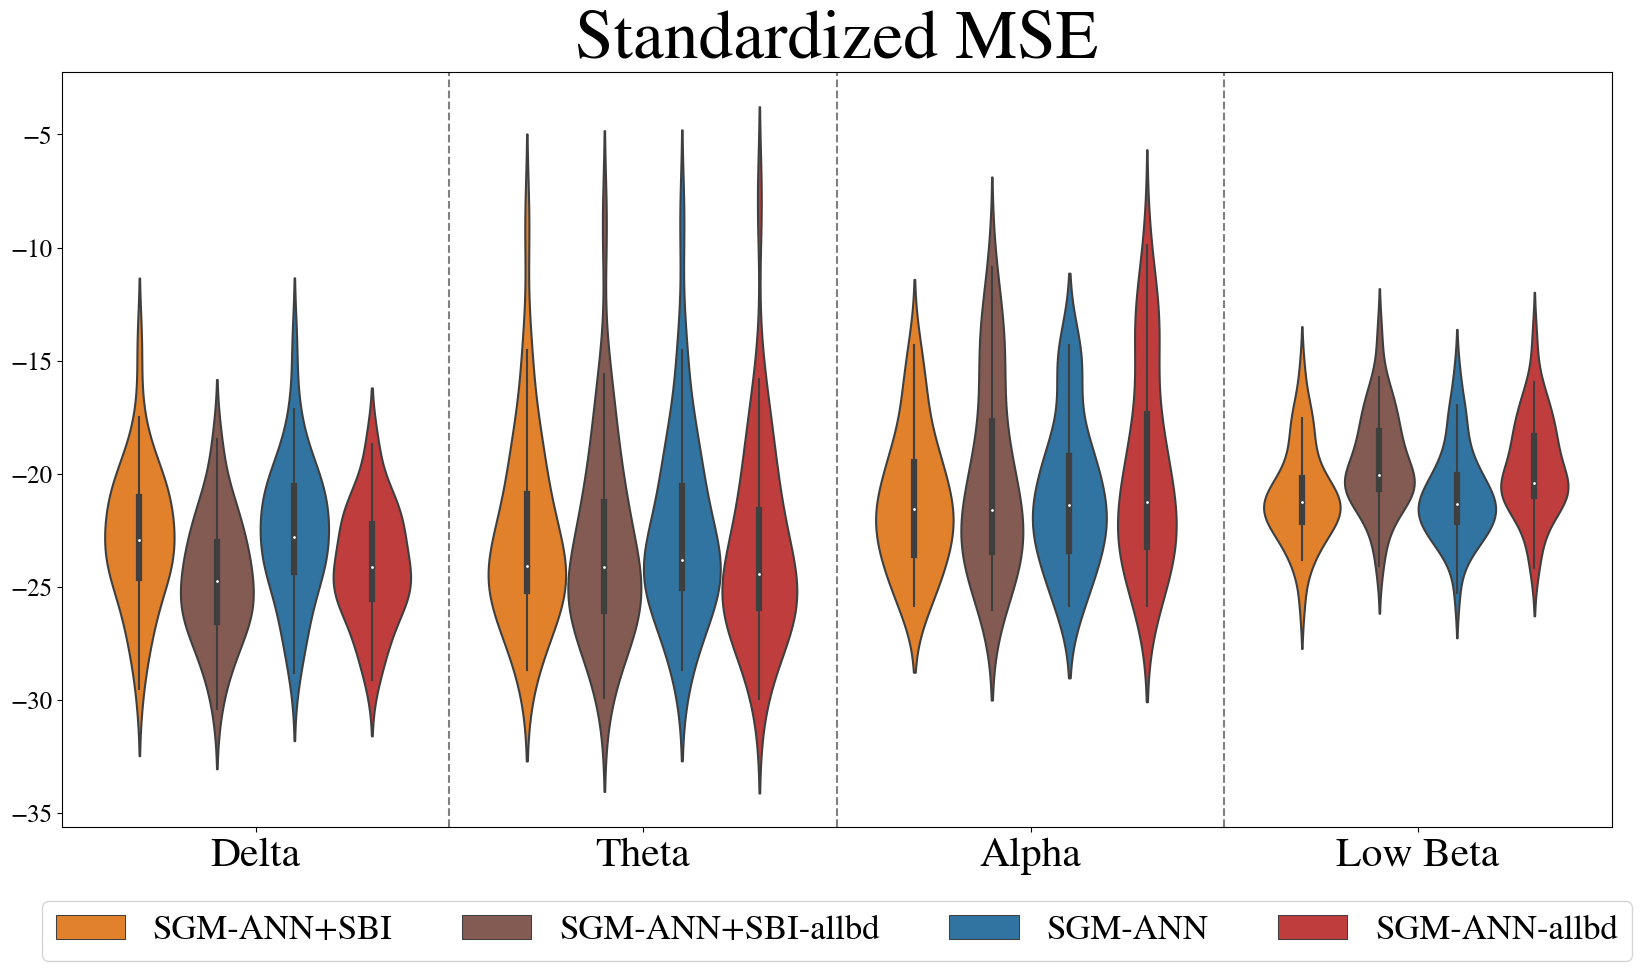

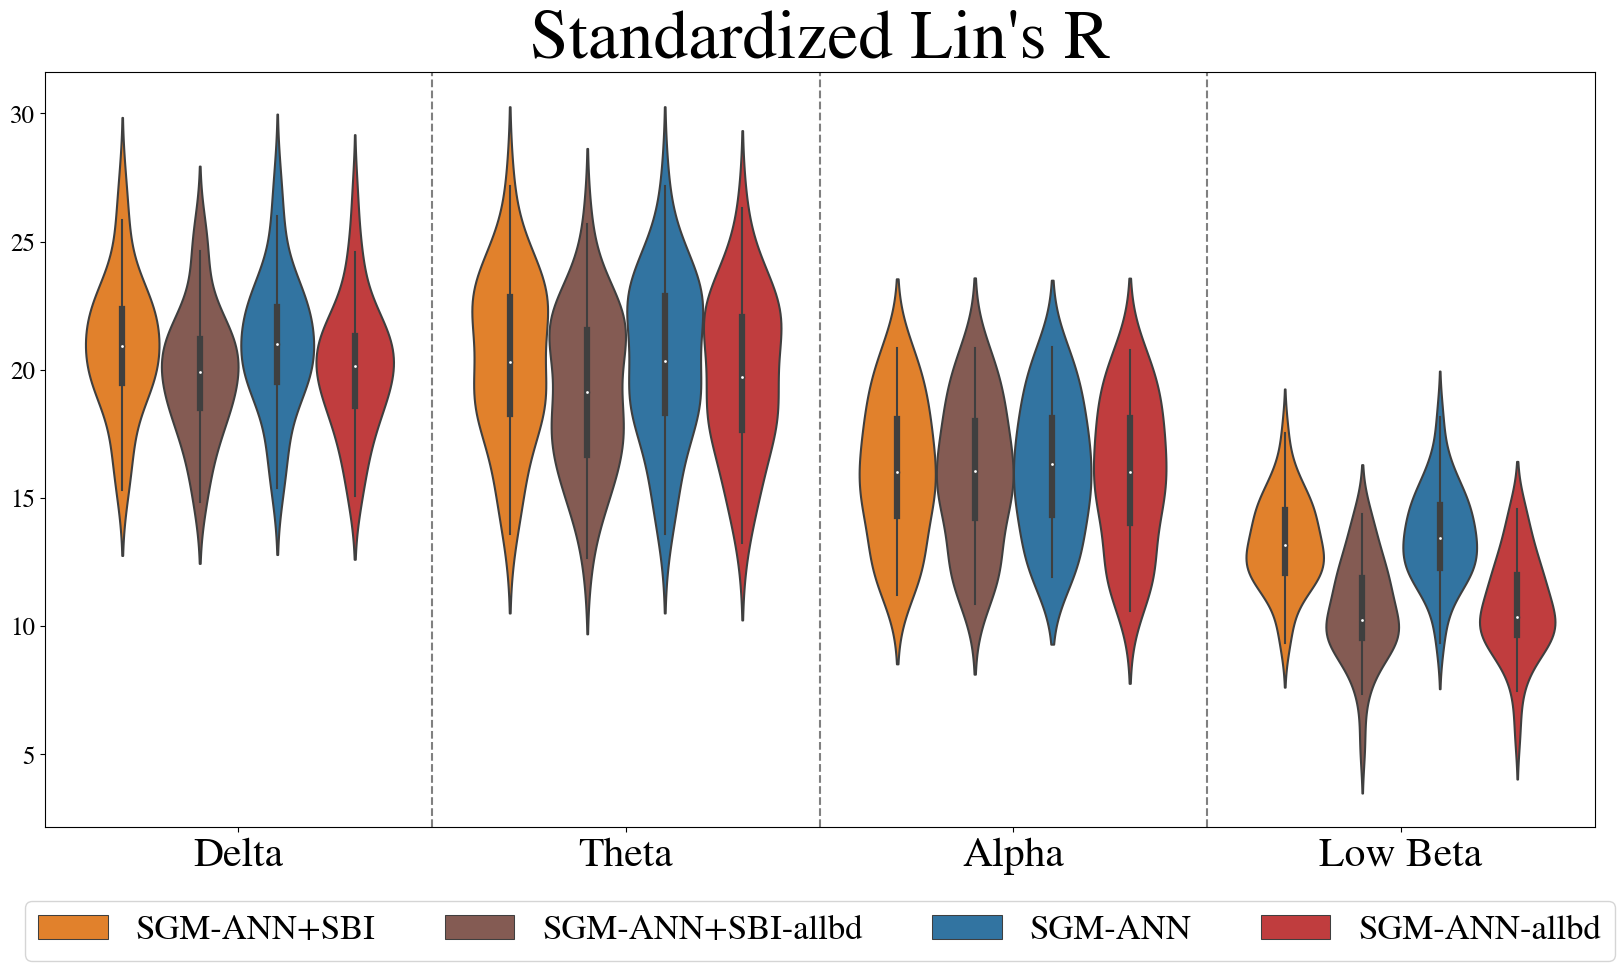

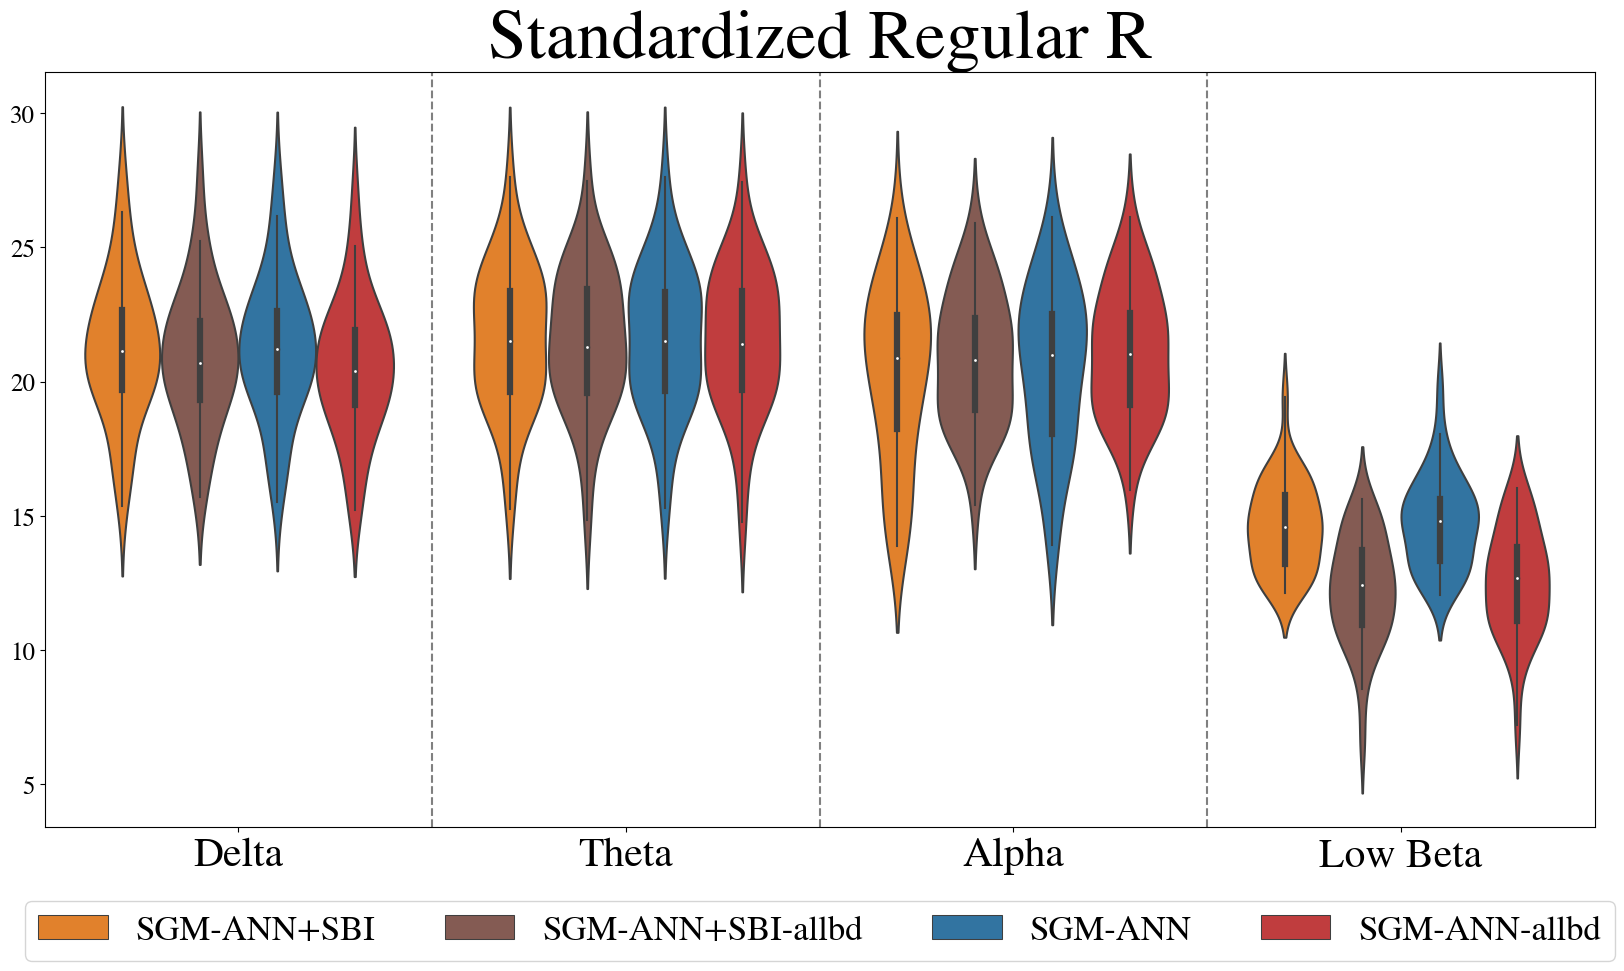

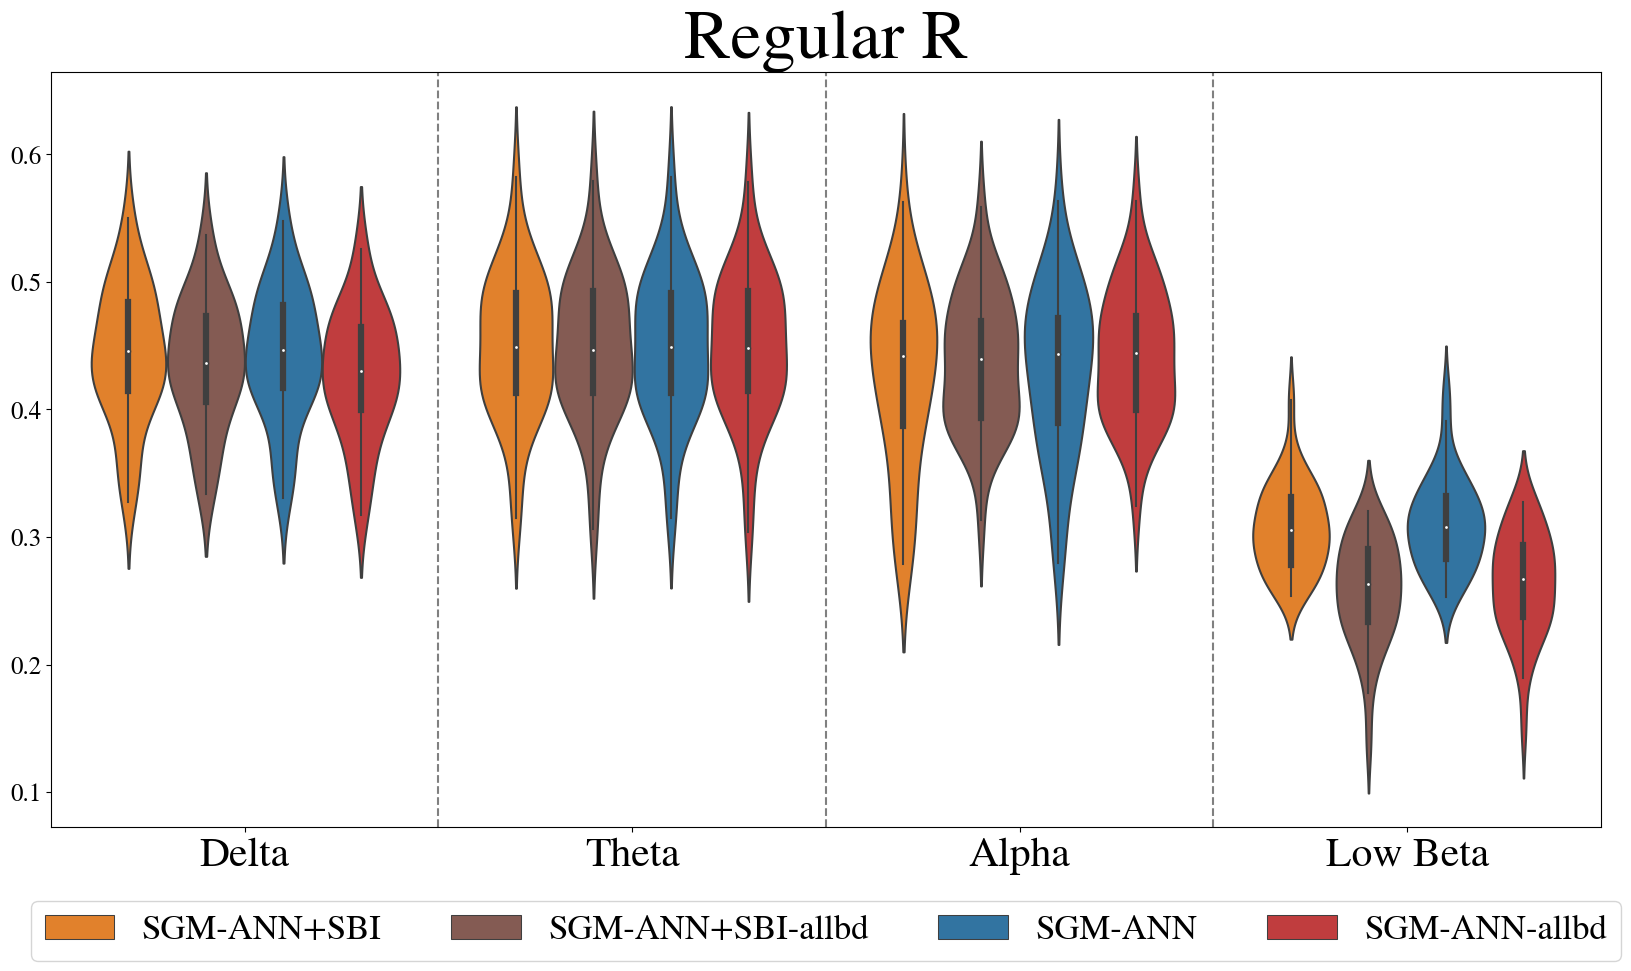

In [27]:
metrics = ["mse_std", "lin_r_std", "reg_r_std", "reg_r"]
                
for metric in metrics:
    plt.figure(figsize=[20, 10])
    plt.title(f"{metrics_name[metrics.index(metric)]}", fontsize=50)
    ax = sns.violinplot(x='Band', y=metric, hue="Method", data=df_plots, split=False, 
                       palette=method_cols)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(np.arange(len(paras.allbds)), bands_name, fontsize=30)
    # put the legend alongside the violinplot
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5) 
    
    keys = df_plots['Band'].unique()
    for key_idx, key in enumerate(keys):
        if key_idx < len(keys) - 1:
            ax.axvline(x=key_idx + 0.5, color='grey', linestyle='--')
    plt.savefig(FIG_ROOT/f"{metric}_cmp_results_supp.jpg")

## FC heatmap

In [28]:

band_fc_res = edict()
for band in paras.allbds:
    _trans_fn = lambda fc: _vec_2mat(_minmax_vec(fc[uptri_idxs]))
    sbi_ann_res = load_pkl(RES_ROOT/(f"rawfc2_SBIxANNBW_{band}_"
                                     f"ep{paras.nepoch}_"
                                     f"num1000_densitynsf_MR3_noise_sd120_"
                                     f"addv{paras.add_v*100:.0f}"
                                     f"/inf_res.pkl"), verbose=False);
    sbi_ann_ab_res = load_pkl(RES_ROOT/(f"rawfc2allbd_SBIxANNALLBD_"
                                        f"{'-'.join(paras.allbds)}_"
                                        f"ep{paras.nepoch}_"
                                        f"num1000_densitynsf_MR3_noise_sd120_"
                                        f"addv{paras.add_v*100:.0f}"
                                        f"/inf_res.pkl"), verbose=False);
    empfcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);
    
    fcss = edict()
    fcss["SGM"] = np.array([_trans_fn(np.abs(est_FC)) 
                                    for est_FC in sbi_ann_res.est_FCs]);
    fcss["SGMAB"]= np.array([_trans_fn(np.abs(est_FC) )
                                         for est_FC in sbi_ann_ab_res[f"est_FCs_{band}"]])
    fcss["SC"] = scs
    fcss["efc"] = np.array([_trans_fn(np.abs(fc)) for fc in empfcs])
    band_fc_res[band] = fcss

In [29]:
# output FCs
for band in paras.allbds:
    fcss = band_fc_res[band]
    for key in ["efc", "SGM", "SGMAB"]:
        sns.heatmap(fcss[key].mean(axis=0), 
                    square=True, vmax=1, vmin=0, 
                    cbar=False, cmap="viridis")
        plt.yticks([])
        plt.xticks([]);
        plt.savefig(FIG_ROOT/f"FC_{band}_{key}.jpg")
    plt.close()

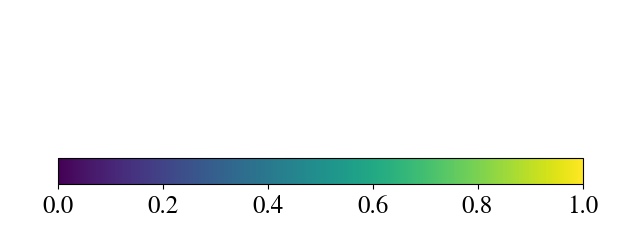

In [153]:
# get colorbar
import matplotlib as mpl

# 创建一个图形和坐标轴
fig, ax = plt.subplots(figsize=(8, 2))
plt.subplots_adjust(top=1)

# 创建一个 ScalarMappable 对象，并设置 colormap（这里使用 'viridis'）
sm = mpl.cm.ScalarMappable(cmap='viridis')
# 这是重要的一步，虽然我们不使用这个对象来绘图
# 我们还需要这样来“激活”我们的 colormap
sm.set_array([])

# 添加 colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')

# 如果需要，可以通过 cbar.set_label 添加标签
#cbar.set_label('My Colorbar Label', size=12)

# 隐藏不需要的坐标轴
ax.axis('off')

plt.savefig(FIG_ROOT/f"FC_colorbar.jpg")

## KDE

In [149]:
from scipy.stats import gaussian_kde
from scipy.signal import savgol_filter
def _kde_plot(vec, prior_bd, label):
    kde = gaussian_kde(vec);
    xrange = np.linspace(prior_bd[0]*0.5,  prior_bd[1]*1.2, 200)
    kde_values = kde(xrange)+1e-2;
    smoothed_kde_values  = np.exp(savgol_filter(np.log(kde_values), window_length=7, polyorder=1))
    smoothed_kde_values = smoothed_kde_values/smoothed_kde_values.mean()/np.diff(prior_bd)
    plt.plot(xrange, smoothed_kde_values, label=label)

names = ["TauC", "Speed", "alpha"]
latex_names = [r"$\tau_G$ (ms)", r"$v$ (m/s)", r"$\alpha$ (a.u.)"]
par_low = np.asarray([0.005, 5, 0.1])
par_high = np.asarray([0.03, 20, 1])
prior_bds = np.array([par_low, par_high]).T;
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=1), prior_bds=prior_bds);

In [150]:
post_spss = edict()
for band in paras.allbds:
    print(band)
    bw_res_fils = list(RES_ROOT.glob(f"rawfc2_SBIxANNBW_{band}_"
                  f"ep{paras.nepoch}_"
                  f"num1000_densitynsf_MR3_noise_sd120_"
                  f"addv{paras.add_v*100:.0f}"
                  f"/ind*.pkl"))
    bw_res_fils = sorted(bw_res_fils, key=lambda p: int(p.stem.split("ind")[-1]));
    
    
    post_spss[band] = []
    for fil in bw_res_fils:
        res = load_pkl(fil, verbose=False);
        sps = res.sample((1000, ));
        post_sps = _theta_raw_2out(sps.numpy());
        post_spss[band].append(post_sps)

delta


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

alpha


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

beta_l


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [151]:
post_spss["allbd"] = []
ab_res_fils = list(RES_ROOT.glob(f"rawfc2allbd_SBIxANNALLBD_"
                                 f"{'-'.join(paras.allbds)}_"
                                 f"ep{paras.nepoch}_"
                                 f"num1000_densitynsf_MR3_noise_sd120_"
                                 f"addv{paras.add_v*100:.0f}"
                                 f"/ind*.pkl"))
ab_res_fils = sorted(ab_res_fils, key=lambda p: int(p.stem.split("ind")[-1]));
for fil in ab_res_fils:
    res = load_pkl(fil, verbose=False);
    sps = res.sample((1000, ));
    post_sps = _theta_raw_2out(sps.numpy());
    post_spss["allbd"].append(post_sps)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

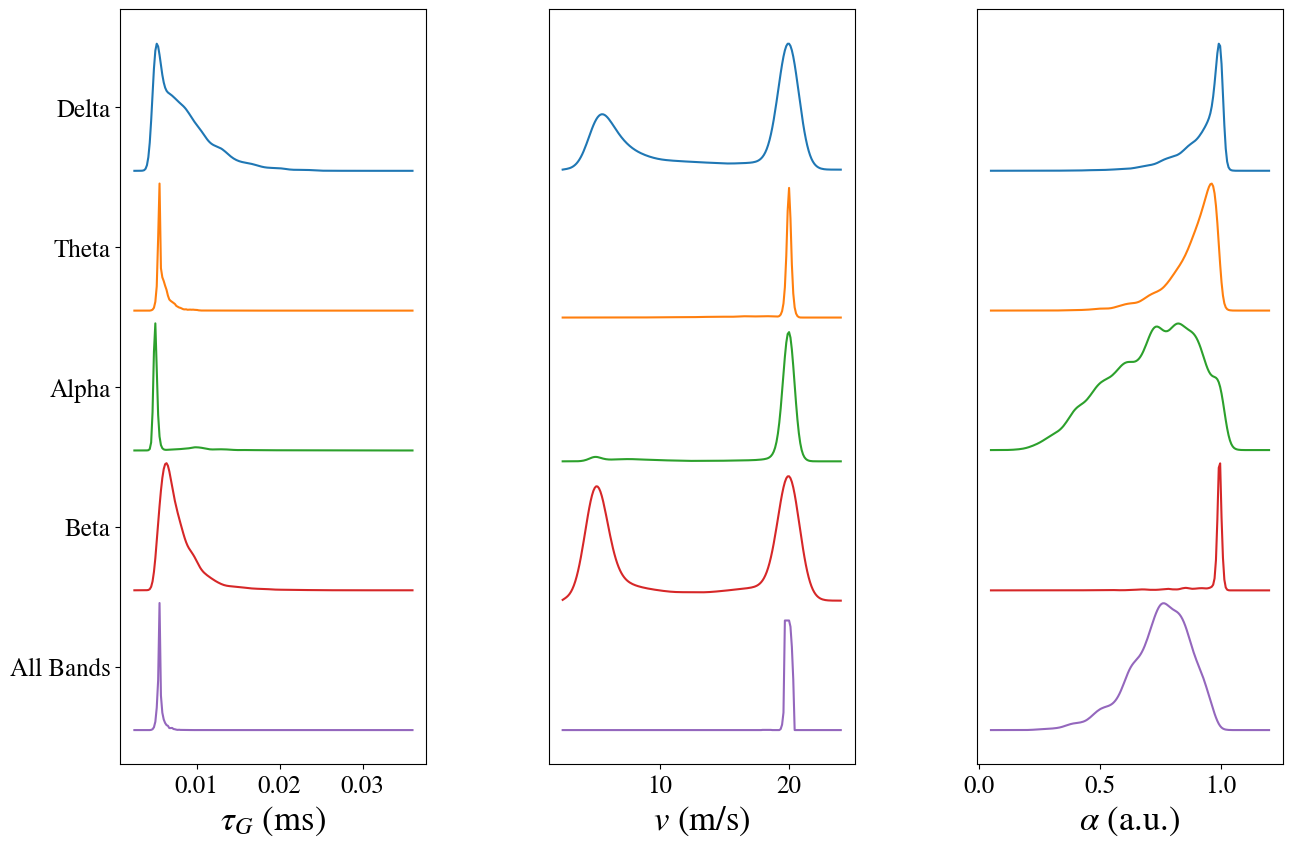

In [161]:
bd_names = ["delta", "theta", "alpha", "beta_l", "allbd"]
bd_names_plot = ["Delta", "Theta", "Alpha", "Beta", "All Bands"]
_prefn = lambda x: np.array(x).reshape(-1, 3)

intv = 1.1
plt.figure(figsize=[15, 10])
for para_idx in [0, 1, 2]:
    prior_bd = prior_bds[para_idx]
    xrange = np.linspace(prior_bd[0]*0.5,  prior_bd[1]*1.2, 200)
    
    plt.subplot(1, 3, para_idx+1)
    for ix, cur_bd in enumerate(bd_names):
        cur_data = _prefn(post_spss[cur_bd]);
        vec = cur_data[:, para_idx]
        kde = gaussian_kde(vec);
        kde_values = kde(xrange)+1e-2;
        smoothed_kde_values  = np.exp(savgol_filter(np.log(kde_values), window_length=7, polyorder=1))
        kde_values_norm = smoothed_kde_values/smoothed_kde_values.max();
        plt.plot(xrange, kde_values_norm+(len(bd_names)-ix-1)*intv)
    ytick_locs = 0.5+np.arange(0, 5)*intv
    if para_idx == 0:
        plt.yticks(ytick_locs, bd_names_plot[::-1])
    else:
        plt.yticks([])
    plt.xlabel(latex_names[para_idx])
plt.savefig(FIG_ROOT/f"norm_KDE.jpg")

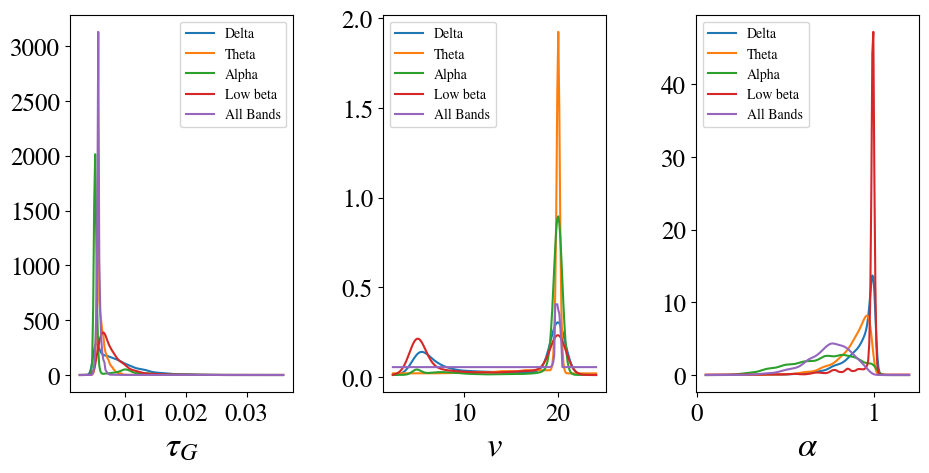

In [53]:
bd_names = ["delta", "theta", "alpha", "beta_l", "allbd"]
bd_names_plot = ["Delta", "Theta", "Alpha", "Low beta", "All Bands"]
_prefn = lambda x: np.array(x).mean(axis=1).reshape(-1, 3)
_prefn = lambda x: np.array(x).reshape(-1, 3)

plt.figure(figsize=[15, 5])
para_idx = 2
cur_bd = bd_names[0]
for para_idx in [0, 1, 2]:
    plt.subplot(1, 4, para_idx+1)
    for cur_bd in bd_names:
        cur_data = _prefn(post_spss[cur_bd]);
        #sns.kdeplot(cur_data[:, para_idx], label=f"{bd_names_plot[bd_names.index(cur_bd)]}")
        _kde_plot(cur_data[:, para_idx], prior_bds[para_idx], 
                  label=f"{bd_names_plot[bd_names.index(cur_bd)]}")
        #if para_idx == 0:
        #    plt.xlim([prior_bds[para_idx][0]*0.1, 0.02])
        plt.ylabel("")
        plt.xlabel(latex_names[para_idx])
        plt.legend(fontsize=10)

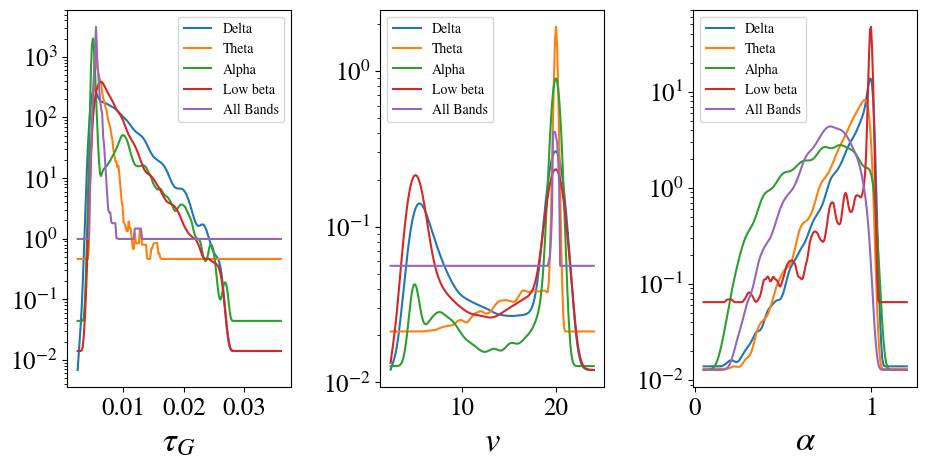

In [43]:
bd_names = ["delta", "theta", "alpha", "beta_l", "allbd"]
bd_names_plot = ["Delta", "Theta", "Alpha", "Low beta", "All Bands"]
_prefn = lambda x: np.array(x).mean(axis=1).reshape(-1, 3)
_prefn = lambda x: np.array(x).reshape(-1, 3)

plt.figure(figsize=[15, 5])
para_idx = 2
cur_bd = bd_names[0]
for para_idx in [0, 1, 2]:
    plt.subplot(1, 4, para_idx+1)
    for cur_bd in bd_names:
        cur_data = _prefn(post_spss[cur_bd]);
        #sns.kdeplot(cur_data[:, para_idx], label=f"{bd_names_plot[bd_names.index(cur_bd)]}")
        _kde_plot(cur_data[:, para_idx], prior_bds[para_idx], 
                  label=f"{bd_names_plot[bd_names.index(cur_bd)]}")
        #if para_idx == 0:
        #    plt.xlim([prior_bds[para_idx][0]*0.1, 0.02])
        plt.yscale("log")
        plt.ylabel("")
        plt.xlabel(latex_names[para_idx])
        plt.legend(fontsize=10)

## Eig curve

In [175]:
_paras = edict()
_paras.delta = [2, 3.5]
_paras.theta = [4, 7]
_paras.alpha = [8, 12]
_paras.beta_l = [13, 20]

In [176]:
from forward import network_transfer_macrostable as nt

par_low = np.asarray([0.005, 5, 0.1])
par_high = np.asarray([0.03, 20, 1])
prior_bds = np.array([par_low, par_high]).T;
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=1), prior_bds=prior_bds);

def _get_lam(raw_params, brain, freq):
    params = _theta_raw_2out(raw_params)
    
    params_dict = dict()
    params_dict["tauC"] =  params[0]
    params_dict["speed"] =  params[1]
    params_dict["alpha"] =  params[2]
    _, U, flam, lam = nt.network_transfer_local_fc_alpha(brain , params_dict, freq, is_full=True)
    return U[:68, :68], flam[:68], lam[:68]

brains = []
for cur_ind_idx in range(36):
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome =  _add_v2con(ind_conn[:, :, cur_ind_idx], paras.add_v)
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    brains.append(brain)

In [177]:
band_fc_res = edict()
for band in paras.allbds:
    _trans_fn = lambda fc: _vec_2mat(_minmax_vec(fc[uptri_idxs]))
    sbi_ann_res = load_pkl(RES_ROOT/(f"rawfc2_SBIxANNBW_{band}_"
                                     f"ep{paras.nepoch}_"
                                     f"num1000_densitynsf_MR3_noise_sd120_"
                                     f"addv{paras.add_v*100:.0f}"
                                     f"/inf_res.pkl"), verbose=False);
    sbi_ann_ab_res = load_pkl(RES_ROOT/(f"rawfc2allbd_SBIxANNALLBD_"
                                        f"{'-'.join(paras.allbds)}_"
                                        f"ep{paras.nepoch}_"
                                        f"num1000_densitynsf_MR3_noise_sd120_"
                                        f"addv{paras.add_v*100:.0f}"
                                        f"/inf_res.pkl"), verbose=False);
    empfcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);
    
    fcss = edict()
    fcss["SGM"] = np.array([np.abs(est_FC) for est_FC in sbi_ann_res.est_FCs]);
    fcss["SGMAB"]= np.array([np.abs(est_FC) for est_FC in sbi_ann_ab_res[f"est_FCs_{band}"]])
    fcss["SC"] = scs
    fcss["efc"] = np.array([np.abs(fc) for fc in empfcs])
    band_fc_res[band] = fcss

In [178]:
post_spss = edict()
for band in paras.allbds:
    print(band)
    bw_res_fils = list(RES_ROOT.glob(f"rawfc2_SBIxANNBW_{band}_"
                  f"ep{paras.nepoch}_"
                  f"num1000_densitynsf_MR3_noise_sd120_"
                  f"addv{paras.add_v*100:.0f}"
                  f"/ind*.pkl"))
    bw_res_fils = sorted(bw_res_fils, key=lambda p: int(p.stem.split("ind")[-1]));
    
    
    post_spss[band] = []
    for fil in bw_res_fils:
        res = load_pkl(fil, verbose=False);
        sps = res.sample((1000, ));
        post_sps = _theta_raw_2out(sps.numpy());
        post_spss[band].append(post_sps)

delta


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

alpha


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

beta_l


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

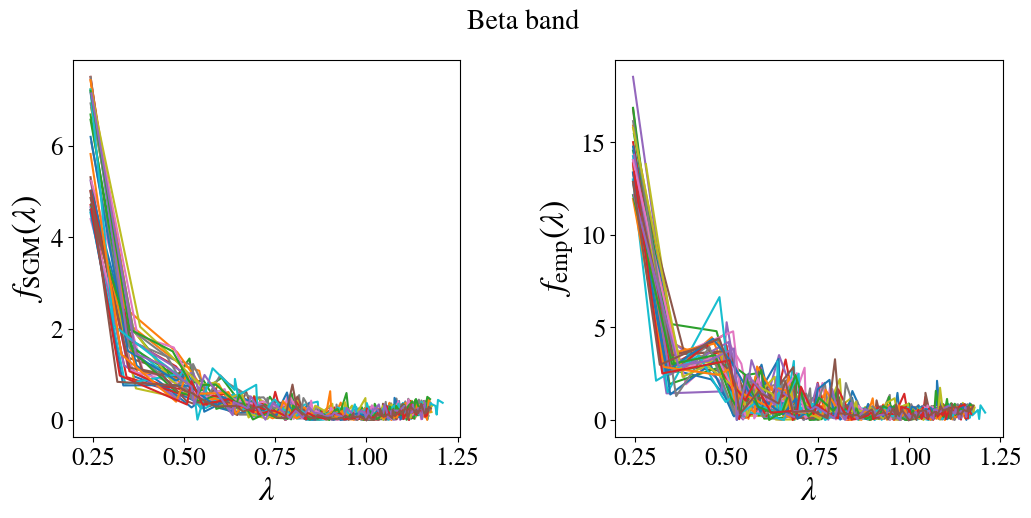

In [189]:
band = "beta_l"
band_name = "Beta"
flams = []
lams = []
empFC_UFU_diags = []
estFC_UFU_diags = []

for sub_idx in range(36):
    mid_pt = np.mean(_paras[band])
    raw_params = np.mean(np.array(post_spss[band]), axis=1)[sub_idx, :]
    U, flam, lam = _get_lam(raw_params, brains[sub_idx],  mid_pt);
    lam = np.abs(lam)
    estFC = band_fc_res[band]["SGM"][sub_idx];
    estFC_UFU = np.abs(np.matrix.getH(U) @ estFC @ U);
    estFC_UFU_diag = np.diag(estFC_UFU);
    
    empFC = band_fc_res[band]["efc"][sub_idx]
    empFC_UFU = np.abs(np.matrix.getH(U) @ empFC @ U)
    empFC_UFU_diag = np.diag(empFC_UFU)
    
    lams.append(lam)
    flams.append(flam)
    empFC_UFU_diags.append(empFC_UFU_diag)
    estFC_UFU_diags.append(estFC_UFU_diag)
    
plt.figure(figsize=[12, 5])
plt.suptitle(f"{band_name} band", fontsize=20)
plt.subplot(121)
for sub_idx in range(36):
    plt.plot(lams[sub_idx], estFC_UFU_diags[sub_idx])
    plt.ylabel(r"$f_{\rm SGM}(\lambda)$")
    plt.xlabel(r"$\lambda$")
    
plt.subplot(122)
for sub_idx in range(36):
    plt.plot(lams[sub_idx], empFC_UFU_diags[sub_idx])
    plt.ylabel(r"$f_{\rm emp}(\lambda)$")
    plt.xlabel(r"$\lambda$")
plt.savefig(FIG_ROOT/f"lambda_plot_{band}.jpg")